In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import pandas as pd
from zipfile import ZipFile
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tensorflow.keras.utils import plot_model

In [2]:
zip_file = ZipFile('basketball_data.zip')
games_season_enriched, games_season, games_tourney = \
[pd.read_csv(zip_file.open(text_file.filename))
 for text_file in zip_file.infolist()
 if text_file.filename.endswith('.csv')]

games_season_enriched.shape, games_season.shape, games_tourney.shape

((4234, 10), (312178, 8), (4234, 9))

# Two-output models

## Simple model with 2 outputs

In [3]:
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model
input_tensor = Input(shape=(1,))
output_tensor = Dense(2)(input_tensor)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 2)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


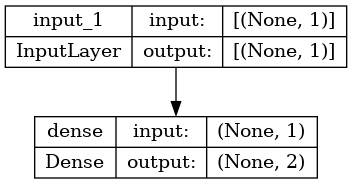

In [4]:
model = Model(input_tensor, output_tensor)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()
plot_model(model, expand_nested=True, show_shapes=True)

## Enrich the tournament data (from previous chapter)

### Team strenght shared model

In [5]:
from tensorflow.keras.layers import Embedding, Flatten
team_lookup = Embedding(input_dim=games_season['team_1'].unique().shape[0], #n_teams
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

teamid_in = Input(shape=(1,))
strength_lookup = team_lookup(teamid_in)
strength_lookup_flat = Flatten()(strength_lookup)
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

### Enrichment model

In [6]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')
# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')
# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)
# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)
# Make a Model
enrichment_model = Model([team_in_1, team_in_2, home_in], out)
# Compile the model
enrichment_model.compile(optimizer='adam', loss='mean_absolute_error')

In [7]:
# Fit the model to the games_season dataset
enrichment_model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=100,
          verbose=True,
          validation_split=0.1,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
enrichment_model.evaluate([games_tourney['team_1'],
                           games_tourney['team_2'],
                           games_tourney['home']],
                          games_tourney['score_diff'], verbose=False)

Epoch 1/100
138/138 [==============================] - 1s 1ms/step - loss: 12.1641 - val_loss: 11.9764
Epoch 2/100
138/138 [==============================] - 0s 933us/step - loss: 12.1134 - val_loss: 12.3089
Epoch 3/100
138/138 [==============================] - 0s 948us/step - loss: 12.0555 - val_loss: 12.7177
Epoch 4/100
138/138 [==============================] - 0s 937us/step - loss: 11.9917 - val_loss: 13.1771
Epoch 5/100
138/138 [==============================] - 0s 923us/step - loss: 11.9273 - val_loss: 13.6872
Epoch 6/100
138/138 [==============================] - 0s 940us/step - loss: 11.8644 - val_loss: 14.2075
Epoch 7/100
138/138 [==============================] - 0s 930us/step - loss: 11.8072 - val_loss: 14.7337
Epoch 8/100
138/138 [==============================] - 0s 905us/step - loss: 11.7541 - val_loss: 15.2550
Epoch 9/100
138/138 [==============================] - 0s 886us/step - loss: 11.7061 - val_loss: 15.7474
Epoch 10/100
138/138 [==============================] - 0

9.630311012268066

In [8]:
pred = enrichment_model.predict([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']])
games_tourney['pred'] = pred
games_tourney.head()

133/133 [==============================] - 0s 398us/step


,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won,pred
0,1985,288,73,0,-3,-9,41,50,0,-7.454697
1,1985,5929,73,0,4,6,61,55,1,-2.458919
2,1985,9884,73,0,5,-4,59,63,0,-0.289184
3,1985,73,288,0,3,9,50,41,1,-0.554029
4,1985,3920,410,0,1,-9,54,63,0,0.555605


## Fitting a model with 2 outputs

In [9]:
games_tourney_train = games_tourney[games_tourney['season']<2010]
games_tourney_test = games_tourney[games_tourney['season']>=2010]

In [10]:
games_tourney_train[['seed_diff', 'score_1', 'score_2']].head()

,seed_diff,score_1,score_2
0,-3,41,50
1,4,61,55
2,5,59,63
3,3,50,41
4,1,54,63


In [11]:
X = games_tourney_train[['seed_diff']]
y = games_tourney_train[['score_1', 'score_2']]
model.fit(X, y, epochs=500)

Epoch 1/500
99/99 [==============================] - 0s 463us/step - loss: 71.8636
Epoch 2/500
99/99 [==============================] - 0s 496us/step - loss: 71.7647
Epoch 3/500
99/99 [==============================] - 0s 459us/step - loss: 71.6656
Epoch 4/500
99/99 [==============================] - 0s 441us/step - loss: 71.5667
Epoch 5/500
99/99 [==============================] - 0s 433us/step - loss: 71.4677
Epoch 6/500
99/99 [==============================] - 0s 465us/step - loss: 71.3689
Epoch 7/500
99/99 [==============================] - 0s 476us/step - loss: 71.2698
Epoch 8/500
99/99 [==============================] - 0s 456us/step - loss: 71.1705
Epoch 9/500
99/99 [==============================] - 0s 449us/step - loss: 71.0719
Epoch 10/500
99/99 [==============================] - 0s 491us/step - loss: 70.9727
Epoch 11/500
99/99 [==============================] - 0s 443us/step - loss: 70.8740
Epoch 12/500
99/99 [==============================] - 0s 483us/step - loss: 70.7746
E

## Inspecting a 2 output model

Now that the model is fit, you can take a look at what it learned. The dense layer has two weights and two biases. The weights indicate that each additional unit of seed difference for the input data equals about .60 additional points for team 1 (and .60 fewer points for team 2). The bias, or intercept term for each team is about 70 points, indicating that we expect an average basketball team to score about 70 points in an average game. In other words, 2 teams with a 1 point seed difference would be expected to have a score of about 69 to 71, while 2 teams with a 10 point seed difference would be expected to have a score of about 64 to 76. 

In [12]:
model.get_weights()

[array([[ 0.45814985, -0.5228752 ]], dtype=float32),
 array([49.45314, 49.44762], dtype=float32)]

## Evaluating a model with 2 outputs

Evaluating a model with two outputs is very similar to evaluating a model with 1 output, except you provide the evaluation function a dataset with 2 columns of data for the target. In this case, the model performs reasonably well on the test set, but in the exercises, you will add some more data to get better predictions. 

In [13]:
X = games_tourney_test[['seed_diff']]
y = games_tourney_test[['score_1', 'score_2']]
model.evaluate(X, y)

34/34 [==============================] - 0s 502us/step - loss: 19.6108


19.610836029052734

## Exercises

### Simple two-output model

In this exercise, you will use the tournament data to build one model that makes two predictions:
* the scores of both teams in a given game.
Your inputs will be the seed difference of the two teams, as well as the predicted score difference from the model you built in chapter 3.

The output from your model will be the predicted score for team 1 as well as team 2.

This is called **"multiple target regression"**: one model making more than one prediction.

In [14]:
# Define the input
input_tensor = Input((2,))
# Define the output
output_tensor = Dense(2)(input_tensor)
# Create a model
model = Model(input_tensor, output_tensor)
# Compile the model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 1,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

### Fit a model with two outputs

Now that you've defined your 2-output model, fit it to the tournament data. I've split the data into games_tourney_train and games_tourney_test, so use the training set to fit for now.

This model will use the pre-tournament seeds, as well as your pre-tournament predictions from the regular season model you built previously in this course.

As a reminder, this model will predict the scores of both teams.

In [15]:
# Fit the model
model.fit(games_tourney_train[['seed_diff', 'pred']],
  		  games_tourney_train[['score_1', 'score_2']],
  		  verbose=True,
  		  epochs=100,
  		  batch_size=16384)

Epoch 1/100
1/1 [==============================] - 0s 109ms/step - loss: 72.4250
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 66.7129
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 61.0424
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 55.6251
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 50.9917
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 47.4313
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 44.9416
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 43.0203
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 41.4068
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 39.8918
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 38.5421
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 37.5174
Epoch 13/100
1/1 [=============================

### Inspect the model

Now that you've fit your model, let's take a look at it. You can use the .get_weights() method to inspect your model's weights.

The input layer will have 4 weights: 2 for each input times 2 for each output.

The output layer will have 2 weights, one for each output.

In [16]:
# Print the model's weights
print(model.get_weights())

[array([[ 0.16862212, -0.3873646 ],
       [ 0.4091982 , -0.19186677]], dtype=float32), array([73.607574, 71.02431 ], dtype=float32)]


In [17]:
# Print the column means of the training data
print(games_tourney_train.mean())

season        1997.045455
team_1        5546.025568
team_2        5546.025568
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.912247
score_2         71.912247
won              0.500000
pred            -4.711905
dtype: float64


Did you notice that both output weights are about ~61? This is because, on average, a team will score about 72 points in the tournament **BUT THE TRAINING LOSS IS ABOUT 10**

### Evaluate the model

Now that you've fit your model and inspected it's weights to make sure it makes sense, evaluate it on the tournament test set to see how well it performs on new data.

In [18]:
# Evaluate the model on the tournament test data
print(model.evaluate(games_tourney_test[['seed_diff', 'pred']],
                     games_tourney_test[['score_1', 'score_2']], verbose=False))

9.099949836730957


# Single model for classification and regression

## Build a simple regressor/classifier

This is another example of a model with two outputs. In this case, however, rather than using two regression outputs, I have a regression output and a classification output. As before, I define the regression part of this model with a single input and a Dense output layer with a single unit. For the classification part of the model, I use the regression model prediction as input and then add another Dense output layer on top of it using the sigmoid activation, which will map the predicted score differences to probabilities that team 1 wins. 

In [19]:
input_tensor = Input(shape=(1,))
output_tensor_reg = Dense(1)(input_tensor)
output_tensor_class = Dense(1, activation='sigmoid')(output_tensor_reg)

## Make a regressor/classifier model

With two output models, each output needs its own loss function. For this model, I've specified two different loss functions, one for the regression model and one for the classification model. As with all the models in this course, I used adam for the optimizer.

In [20]:
from tensorflow.keras.models import Model
model = Model(input_tensor, [output_tensor_reg, output_tensor_class])
model.compile(loss=['mean_absolute_error',
                    'binary_crossentropy'],
              optimizer='adam')

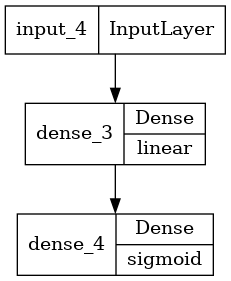

In [21]:
plot_model(model, expand_nested=True, show_layer_activations=True)

## Fit the combination classifier/regressor

To fit the combination classification/regression model, you must provide the y data as a list. Recall that this is similar to the way you built two input models in chapter 2. Use seed_difference as the only input to this model. For the regression output, I use score_difference, and for the classification output, I use whether or not team 1 won the game. I split both of these variables out from the training set and pass them to the fit method as a list. This model fits a bit more quickly than the last one, so I only use 100 epochs.

In [22]:
X = games_tourney_train[['seed_diff']]
y_reg = games_tourney_train[['score_diff']]
y_class = games_tourney_train[['won']]
model.fit(X, [y_reg, y_class], epochs=100)

Epoch 1/100
99/99 [==============================] - 0s 701us/step - loss: 17.6719 - dense_3_loss: 16.8595 - dense_4_loss: 0.8124
Epoch 2/100
99/99 [==============================] - 0s 669us/step - loss: 17.0607 - dense_3_loss: 16.3705 - dense_4_loss: 0.6902
Epoch 3/100
99/99 [==============================] - 0s 664us/step - loss: 16.5080 - dense_3_loss: 15.8992 - dense_4_loss: 0.6088
Epoch 4/100
99/99 [==============================] - 0s 690us/step - loss: 15.9970 - dense_3_loss: 15.4337 - dense_4_loss: 0.5633
Epoch 5/100
99/99 [==============================] - 0s 681us/step - loss: 15.5258 - dense_3_loss: 14.9799 - dense_4_loss: 0.5459
Epoch 6/100
99/99 [==============================] - 0s 682us/step - loss: 15.0864 - dense_3_loss: 14.5438 - dense_4_loss: 0.5426
Epoch 7/100
99/99 [==============================] - 0s 683us/step - loss: 14.6707 - dense_3_loss: 14.1268 - dense_4_loss: 0.5439
Epoch 8/100
99/99 [==============================] - 0s 668us/step - loss: 14.2670 - dense

## Look at the model's weights

This model's weight structure is a bit different from the last model, where both outputs were regression targets.

The first layer has a weight of 1.24 and a bias of almost zero. This means that a 1 unit change in the teams' seed difference yields about 1.24 additional points in their score difference. So 2 teams with a seed difference of 1 would be expected to have team 1 win by 1.2 points. But 2 teams with a seed difference of 10 would be expected to have team 1 win by 12 points.

The next layer maps predicted score difference to predicted win/loss. Recall that the final layer in the model uses sigmoid activation.

In [23]:
model.get_weights()

[array([[1.2390009]], dtype=float32),
 array([-0.00088207], dtype=float32),
 array([[0.14492686]], dtype=float32),
 array([-0.00096333], dtype=float32)]

You can manually calculate the final layer in the model for some example data, to get an understanding of how the model has learned to relate score difference to win probabilities.

Scipy has a function called expit(), which is an efficient implementation of the sigmoid function. Let's manually calculate the win probability for 2 teams that are predicted to have a score difference of 1.

First, multiply 1 by the weight for the final layer in the model: 0.14. Add the bias for the final layer: -0.0009545. Since the bias is very close to zero, the result is still 0.14.

Finally, we apply the sigmoid function to 0.14, which yields a prediction of 0.54.

**In other words, the model has learned that an expected score difference of 1 point is equal to an expected win probability of 54%.**

In [24]:
from scipy.special import expit as sigmoid
sigmoid(1 * 0.14165877 + (-0.0009545))

0.5351181484190471

## Evaluate the model on new data

Finally, you can evaluate the model on new data. First, split the evaluation dataset into a regression target and a classification target, and provide the same list of 2 targets to the evaluate() method.

This outputs 3 numbers now, instead of 1 as with the models we looked at in other chapters:

* The first number is the loss function used by the model, which is the sum of all the output losses.
* The second number is the loss for the regression part of the model
* The third number is the loss for the classification part of the model.

So our model has a mean absolute error of 9.28 and a logloss of 0.58, which is pretty good, but I think you can do better with more data when you try for yourself. 

In [25]:
X = games_tourney_test[['seed_diff']]
y_reg = games_tourney_test[['score_diff']]
y_class = games_tourney_test[['won']]
model.evaluate(X, [y_reg, y_class])

34/34 [==============================] - 0s 641us/step - loss: 9.7282 - dense_3_loss: 9.1414 - dense_4_loss: 0.5868


[9.728167533874512, 9.141377449035645, 0.5867900252342224]

## Exercises

### Classification and regression in one model

Now you will create a different kind of 2-output model. This time, you will predict the score difference, instead of both team's scores and then you will predict the probability that team 1 won the game. This is a pretty cool model: it is going to do both classification and regression!

In this model, turn off the bias, or intercept for each layer. Your inputs (seed difference and predicted score difference) have a mean of very close to zero, and your outputs both have means that are close to zero, so your model shouldn't need the bias term to fit the data well.

In [26]:
games_tourney_train[['seed_diff', 'score_diff']].mean()

seed_diff     0.0
score_diff    0.0
dtype: float64

In [27]:
# Create an input layer with 2 columns
input_tensor = Input((2,))
# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)
# Create the second output (use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)
# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

### Compile and fit the model

Now that you have a model with 2 outputs, compile it with 2 loss functions: mean absolute error (MAE) for 'score_diff' and binary cross-entropy (also known as logloss) for 'won'. Then fit the model with 'seed_diff' and 'pred' as inputs. For outputs, predict 'score_diff' and 'won'.

This model can use the scores of the games to make sure that close games (small score diff) have lower win probabilities than blowouts (large score diff).

The regression problem is easier than the classification problem because MAE punishes the model less for a loss due to random chance. For example, if score_diff is -1 and won is 0, that means team_1 had some bad luck and lost by a single free throw. The data for the easy problem helps the model find a solution to the hard problem.

In [28]:
# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], optimizer=Adam(learning_rate=0.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(games_tourney_train[['seed_diff', 'pred']],
          [games_tourney_train[['score_diff']], games_tourney_train[['won']]],
          epochs=10,
          verbose=True,
          batch_size=16384)

Epoch 1/10
1/1 [==============================] - 0s 198ms/step - loss: 36.5002 - dense_5_loss: 25.1118 - dense_6_loss: 11.3884
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 36.1456 - dense_5_loss: 24.9846 - dense_6_loss: 11.1610
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 35.7934 - dense_5_loss: 24.8574 - dense_6_loss: 10.9360
Epoch 4/10
1/1 [==============================] - 0s 1ms/step - loss: 35.4437 - dense_5_loss: 24.7303 - dense_6_loss: 10.7133
Epoch 5/10
1/1 [==============================] - 0s 1ms/step - loss: 35.0965 - dense_5_loss: 24.6035 - dense_6_loss: 10.4930
Epoch 6/10
1/1 [==============================] - 0s 1ms/step - loss: 34.7521 - dense_5_loss: 24.4769 - dense_6_loss: 10.2752
Epoch 7/10
1/1 [==============================] - 0s 1ms/step - loss: 34.4102 - dense_5_loss: 24.3505 - dense_6_loss: 10.0598
Epoch 8/10
1/1 [==============================] - 0s 1ms/step - loss: 34.0712 - dense_5_loss: 24.2244 - dense_6_loss

### Inspect the model

Now you should take a look at the weights for this model. In particular, note the last weight of the model. This weight converts the predicted score difference to a predicted win probability. If you multiply the predicted score difference by the last weight of the model and then apply the sigmoid function, you get the win probability of the game.

In [29]:
# Print the model weights
print(model.get_weights())

# Print the training data means
print(games_tourney_train[['seed_diff', 'pred']].mean())

[array([[-1.2290437 ],
       [-0.94304866]], dtype=float32), array([[0.76021254]], dtype=float32)]
seed_diff    0.000000
pred        -4.711905
dtype: float64


Now you should take a look at the weights for this model. In particular, note the last weight of the model. This weight converts the predicted score difference to a predicted win probability.

If you multiply the predicted score difference by the last weight of the model and then apply the sigmoid function, you get the win probability of the game.

In [30]:
# Import the sigmoid function from scipy
from scipy.special import expit as sigmoid

# Weight from the model
weight = 0.14

# Print the approximate win probability predicted close game
print(sigmoid(1 * weight))

# Print the approximate win probability predicted blowout game
print(sigmoid(10 * weight))

0.5349429451582145
0.8021838885585818


So sigmoid(1 * 0.14) is 0.53, which represents a pretty close game and sigmoid(10 * 0.14) is 0.80, which represents a pretty likely win. In other words, if the model predicts a win of 1 point, it is less sure of the win than if it predicts 10 points. 

### Evaluate on new data with two metrics

Now that you've fit your model and inspected its weights to make sure they make sense, evaluate your model on the tournament test set to see how well it does on new data.

Note that in this case, Keras will return 3 numbers: the first number will be the sum of both the loss functions, and then the next 2 numbers will be the loss functions you used when defining the model.

Ready to take your deep learning to the next level? Check out "[Convolutional Neural Networks for Image Processing](https://www.datacamp.com/courses/convolutional-neural-networks-for-image-processing)".

In [31]:
# Evaluate the model on new data
print(model.evaluate(games_tourney_test[['seed_diff', 'pred']],
                     [games_tourney_test[['score_diff']], games_tourney_test[['won']]], verbose=False))

[29.374740600585938, 21.493305206298828, 7.881437301635742]


# Wrap-up

## So far...
* Functional API
* Shared layers
* Categorical embeddings
* Multiple inputs
* Multiple outputs
* Regression / Classification in one model

## Shared layers

In this final video, I'd like to discuss some real-world uses cases of what you've learned. Shared layers are incredibly useful when you want to compare two things. For example, we compared two basketball teams to decide how different they were in their ability to score points in a basketball game, using a shared embedding model. In academic research, shared models are known as "siamese networks", which are used to calculate things like document similarity, using shared embedding layer and a shared long-short-term memory layer (or LSTM layer), and then comparing the LSTM outputs. Since both documents are encoded with the same embedding layer and the same LSTM layer, the model learns a representation of the documents that can be used to compare them. Here are some links for further reading. In this final video, I'd like to discuss some real-world uses cases of what you've learned. Shared layers are incredibly useful when you want to compare two things. For example, we compared two basketball teams to decide how different they were in their ability to score points in a basketball game, using a shared embedding model. In academic research, shared models are known as "siamese networks", which are used to calculate things like document similarity, using shared embedding layer and a shared long-short-term memory layer (or LSTM layer), and then comparing the LSTM outputs. Since both documents are encoded with the same embedding layer and the same LSTM layer, the model learns a representation of the documents that can be used to compare them. Here are some links for further reading. 

* Useful for making comparisons
    * Basketball teams
    * Image similarity / retrieval
    * Document similarity
* Known in the academic literature as Siamese networks
    * https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07
    * http://people.csail.mit.edu/jonasmueller/info/MuellerThyagarajan_AAAI16.pdf

## Multiple inputs

Multiple input networks are especially useful when you want to process different types of data within your model. For example, in our basketball models, we processed team IDs separately, using an embedding layer. For numeric data such as home vs away, we skipped the embedding step and passed it directly to the output. You can extend this concept to build a network that, for example, uses an LSTM to process text, a standard Dense layer to process numerics, and a convolutional layer (or CNN) to process images. I didn't cover LSTMs or CNNs in this course, but once you understand them, you can use this concept to make networks that understand both text and images!

![Image](multiple-inputs-text-numeric-images.png)

The multiple output network you built in chapter 4 is the coolest model of the course. It can do both classification AND regression! I like this model a lot because the regression problem turns out to be a lot easier than the classification problem. In the regression problem, the neural network gets penalized less for random chance. For example, a team that wins by 1 point got really lucky, and the model can use that information. However, in the classification model, winning by 1 point is the same as winning by 10 points. I think it's pretty cool that we can use the output from the easier regression problem to help solve the more difficult classification problem.

## Skip connections

In [19]:
input_tensor = Input((100,))
hidden_tensor = Dense(256, activation='relu')(input_tensor)
hidden_tensor = Dense(256, activation='relu')(hidden_tensor)
hidden_tensor = Dense(256, activation='relu')(hidden_tensor)
output_tensor = Concatenate()([input_tensor, hidden_tensor])
output_tensor = Dense(256, activation='relu')(output_tensor)

[Visualizing the Loss Landscape of Neural Nets](https://arxiv.org/pdf/1712.09913.pdf)